In [1]:
import numpy as np

In [47]:
x = np.array([[1,2,3,3,4,5,6],[2,3,6,4,5,3,1]])
index1 = (x == 3 and x > 3).all()
index2 = x !=3

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [38]:
s = index1*1
s

array([[0, 0, 1, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 1, 0]])

In [48]:
y = np.mean(x, axis = 1)
y

array([3.42857143, 3.42857143])

In [50]:
y = x[[1,0]]
y

array([[2, 3, 6, 4, 5, 3, 1],
       [1, 2, 3, 3, 4, 5, 6]])

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sys
import os
from pathlib import Path

scripts_dir = Path().resolve()
parent_dir = scripts_dir.parent
sys.path.insert(0, str(parent_dir))
import Functions.HMM as HMM
import Functions.kinematics as kinematics
import Functions.patch as patch

import aeon
import aeon.io.api as api
from aeon.io import reader, video
from aeon.schema.dataset import exp02, exp01
from aeon.analysis.utils import visits, distancetravelled

In [3]:
roots = [Path("/ceph/aeon/aeon/code/scratchpad/sleap/multi_point_tracking/multi_animal_CameraTop/predictions_social02/AEON3/analyses"),Path("/ceph/aeon/aeon/code/scratchpad/sleap/multi_point_tracking/multi_animal_CameraTop/predictions_social02/AEON4/analyses")]
if not np.all([path.exists() for path in roots]):
    print("Cannot find root paths. Check path names or connection.")

In [6]:
# Define the root path
root = Path("/ceph/aeon/aeon/code/scratchpad/sleap/multi_point_tracking/multi_animal_CameraTop/predictions_social02/AEON3/analyses")

# List all files in the directory
files = list(root.glob("*"))

# Print the list of files
for file in files:
    print(file)

/ceph/aeon/aeon/code/scratchpad/sleap/multi_point_tracking/multi_animal_CameraTop/predictions_social02/AEON3/analyses/CameraTop_2024-02-17T16-00-00_full_pose.analysis.h5
/ceph/aeon/aeon/code/scratchpad/sleap/multi_point_tracking/multi_animal_CameraTop/predictions_social02/AEON3/analyses/CameraTop_2024-02-11T13-00-00_full_pose_id.analysis.h5
/ceph/aeon/aeon/code/scratchpad/sleap/multi_point_tracking/multi_animal_CameraTop/predictions_social02/AEON3/analyses/CameraTop_2024-02-14T07-00-00_id.analysis.h5
/ceph/aeon/aeon/code/scratchpad/sleap/multi_point_tracking/multi_animal_CameraTop/predictions_social02/AEON3/analyses/CameraTop_2024-02-12T09-00-00_full_pose_id.analysis.h5
/ceph/aeon/aeon/code/scratchpad/sleap/multi_point_tracking/multi_animal_CameraTop/predictions_social02/AEON3/analyses/CameraTop_2024-02-21T23-00-00_full_pose_id_all_frames.analysis.h5
/ceph/aeon/aeon/code/scratchpad/sleap/multi_point_tracking/multi_animal_CameraTop/predictions_social02/AEON3/analyses/CameraTop_2024-02-0

In [11]:
from datetime import datetime

# Extract datetimes and create list of tuples
file_dates = []
for file in files:
    datetime_str = str(file).split('/')[-1].split('_')[1] 
    datetime_obj = datetime.strptime(datetime_str, '%Y-%m-%dT%H-%M-%S')
    file_dates.append((datetime_obj, file))

# Sort the list of tuples by the datetime
file_dates.sort()

# Extract the sorted paths
sorted_paths = [path for _, path in file_dates]

In [30]:
datetime_obj

datetime.datetime(2024, 2, 14, 13, 0)

In [12]:
sorted_paths

[PosixPath('/ceph/aeon/aeon/code/scratchpad/sleap/multi_point_tracking/multi_animal_CameraTop/predictions_social02/AEON3/analyses/CameraTop_2024-01-31T11-00-00_full_pose.analysis.h5'),
 PosixPath('/ceph/aeon/aeon/code/scratchpad/sleap/multi_point_tracking/multi_animal_CameraTop/predictions_social02/AEON3/analyses/CameraTop_2024-01-31T12-00-00_full_pose.analysis.h5'),
 PosixPath('/ceph/aeon/aeon/code/scratchpad/sleap/multi_point_tracking/multi_animal_CameraTop/predictions_social02/AEON3/analyses/CameraTop_2024-01-31T13-00-00_full_pose.analysis.h5'),
 PosixPath('/ceph/aeon/aeon/code/scratchpad/sleap/multi_point_tracking/multi_animal_CameraTop/predictions_social02/AEON3/analyses/CameraTop_2024-01-31T14-00-00_full_pose.analysis.h5'),
 PosixPath('/ceph/aeon/aeon/code/scratchpad/sleap/multi_point_tracking/multi_animal_CameraTop/predictions_social02/AEON3/analyses/CameraTop_2024-01-31T15-00-00_full_pose.analysis.h5'),
 PosixPath('/ceph/aeon/aeon/code/scratchpad/sleap/multi_point_tracking/mult

In [2]:
import h5py

In [39]:
with h5py.File("/ceph/aeon/aeon/code/scratchpad/sleap/multi_point_tracking/multi_animal_CameraTop/predictions_social02/AEON3/analyses/CameraTop_2024-01-31T11-00-00_full_pose.analysis.h5", 'r') as f:
    occupancy_matrix = f['track_occupancy'][:]
    tracks_matrix = f['tracks'][:]
    point_scores = f['point_scores'][:]
    nodes_name = f['node_names'][:]

print(occupancy_matrix.shape)
print(tracks_matrix.shape)

(93451, 1)
(1, 2, 8, 93451)


In [21]:
tracks_matrix[0][0][0]

array([1317.21496582, 1317.23291016, 1317.22729492, ..., 1315.24230957,
       1315.24938965, 1315.22729492])

In [27]:
with h5py.File("/ceph/aeon/aeon/code/scratchpad/sleap/multi_point_tracking/multi_animal_CameraTop/predictions_social02/AEON3/analyses/CameraTop_2024-02-18T00-00-00_full_pose.analysis.h5", 'r') as f:
    nodes_name = f['node_names'][:]
    
nodes_name

array([b'nose', b'head', b'right_ear', b'left_ear', b'spine1', b'spine2',
       b'spine3', b'spine4'], dtype='|S9')

In [29]:
with h5py.File("/ceph/aeon/aeon/code/scratchpad/sleap/multi_point_tracking/multi_animal_CameraTop/predictions_social02/AEON3/analyses/CameraTop_2024-02-18T00-00-00_full_pose.analysis.h5", 'r') as f:
    point_scores = f['point_scores'][:]
    
point_scores

array([[[0.8881492 , 0.87080151, 0.86788863, ..., 0.25867957,
         0.25843054, 0.25322658],
        [0.79193133, 0.78218979, 0.76903981, ..., 0.22301875,
         0.22310005, 0.21862741],
        [0.81698072, 0.81525683, 0.80524981, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.8467856 , 0.8297447 , 0.82399213, ..., 0.83022249,
         0.83092046, 0.83330691],
        [0.6906811 , 0.64552605, 0.63290536, ..., 0.47683233,
         0.47605273, 0.48175582],
        [0.53836501, 0.49064359, 0.48235756, ..., 0.55492461,
         0.55504107, 0.55865145]]])

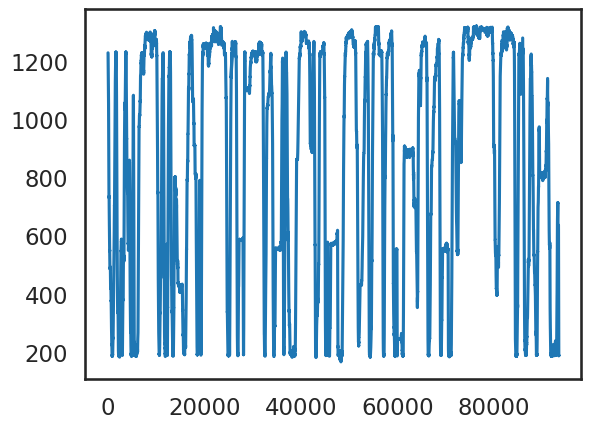

In [40]:
plt.plot(tracks_matrix[0][0][7])
plt.show()